<a href="https://colab.research.google.com/github/rsanchezgarc/AI-ML-analytics-IE/blob/main/notebooks/autoencoders/autoencoders_celebA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Installation

In [23]:
# 1. Install dependencies
!pip install --quiet pytorch-lightning

## 2. Imports

In [24]:
import os
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms.v2 as transforms
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from torchvision.datasets import CelebA

pl.seed_everything(42)

INFO:lightning_fabric.utilities.seed:Seed set to 42


42

## 3. Data download

In [25]:
file_id = "1X5AIfVSbroK4g3NQfrMtpUMFawBjxlIB"
!gdown {file_id}
!unzip -u celeba_data.zip > /dev/null

Downloading...
From (original): https://drive.google.com/uc?id=1X5AIfVSbroK4g3NQfrMtpUMFawBjxlIB
From (redirected): https://drive.google.com/uc?id=1X5AIfVSbroK4g3NQfrMtpUMFawBjxlIB&confirm=t&uuid=20e9fcfb-24f0-466a-b394-265b785471fe
To: /content/celeba_data.zip
100% 2.88G/2.88G [00:42<00:00, 67.4MB/s]


## 4. Visualiation utilities

In [26]:
# 4. Visualization utilities
celeba_attrs = [
    '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes',
    'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair',
    'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin',
    'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones',
    'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
    'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks',
    'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
    'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young'
]

def process_image_for_display(img):
    """Convert tensor image to a displayable NumPy array."""
    if torch.is_tensor(img):
        img = img.cpu().detach()
        if img.shape[0] == 3:
            img = img.permute(1, 2, 0)
        img = img.numpy()
    if img.min() < 0 or img.max() > 1: #Normalization according ImageNet, not really used
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    return np.clip(img, 0, 1)

def visualize_features(features, attributes, cluster_labels, images, title, selected_attrs=None):
    """t-SNE visualization with attribute combinations."""
    tsne = TSNE(n_components=2, random_state=42)
    features_2d = tsne.fit_transform(features)
    fig, ax = plt.subplots(figsize=(12, 10))
    if selected_attrs is None:
        selected_attrs = [20]  # Default to 'Male'
    selected_attrs = selected_attrs[:2]
    attr_names = [celeba_attrs[idx] if idx < len(celeba_attrs) else f"Attribute {idx}" for idx in selected_attrs]
    colors = plt.cm.tab10(np.linspace(0, 1, 10))
    if len(selected_attrs) == 1:
        feature_combinations = [(0,), (1,)]
        combination_labels = [f"{attr_names[0]}=No", f"{attr_names[0]}=Yes"]
        combination_colors = [colors[0], colors[1]]
    else:
        feature_combinations = [(0, 0), (0, 1), (1, 0), (1, 1)]
        combination_labels = [
            f"{attr_names[0]}=No, {attr_names[1]}=No",
            f"{attr_names[0]}=No, {attr_names[1]}=Yes",
            f"{attr_names[0]}=Yes, {attr_names[1]}=No",
            f"{attr_names[0]}=Yes, {attr_names[1]}=Yes"
        ]
        combination_colors = [colors[i] for i in range(4)]
    for i, combination in enumerate(feature_combinations):
        mask = np.ones(len(features), dtype=bool)
        for j, attr_idx in enumerate(selected_attrs):
            mask = mask & (attributes[:, attr_idx] == combination[j])
        if mask.any():
            ax.scatter(features_2d[mask, 0], features_2d[mask, 1],
                       c=[combination_colors[i]], marker='o', alpha=0.7,
                       label=combination_labels[i])
    legend_handles = [Line2D([0], [0], color=combination_colors[i],
                             marker='o', linestyle='None', markersize=10,
                             label=combination_labels[i])
                      for i in range(len(feature_combinations))]
    ax.legend(handles=legend_handles, title='Attribute Combinations', loc='best')
    # Add inset images for a representative image from each combination
    for i, combination in enumerate(feature_combinations):
        mask = np.ones(len(features), dtype=bool)
        for j, attr_idx in enumerate(selected_attrs):
            mask = mask & (attributes[:, attr_idx] == combination[j])
        combo_indices = np.where(mask)[0]
        if len(combo_indices) > 0:
            combo_features = features[combo_indices]
            combo_mean = np.mean(combo_features, axis=0)
            distances = np.linalg.norm(combo_features - combo_mean, axis=1)
            rep_idx = combo_indices[np.argmin(distances)]
            x, y = features_2d[rep_idx]
            inset_ax = inset_axes(ax, width=0.35, height=0.35,
                                  loc=10,
                                  bbox_transform=ax.transData,
                                  bbox_to_anchor=(x, y),
                                  borderpad=0)
            img = process_image_for_display(images[rep_idx])
            inset_ax.imshow(img)
            inset_ax.axis('off')
            inset_ax.set_title(combination_labels[i], fontsize=8)
    ax.set_title(title)
    plt.tight_layout()
    return fig

def visualize_reconstructions(original_images, reconstructed_images, attributes=None, attr_idx=None, num_examples=10):
    """Visualize original and reconstructed images side by side."""
    fig, axes = plt.subplots(2, num_examples, figsize=(2 * num_examples, 4))
    if attributes is not None and attr_idx is not None:
        pos_indices = np.where(attributes[:, attr_idx] == 1)[0]
        neg_indices = np.where(attributes[:, attr_idx] == 0)[0]
        num_pos = min(num_examples // 2, len(pos_indices))
        num_neg = min(num_examples - num_pos, len(neg_indices))
        pos_selected = np.random.choice(pos_indices, num_pos, replace=False)
        neg_selected = np.random.choice(neg_indices, num_neg, replace=False)
        indices = np.concatenate([pos_selected, neg_selected])
        np.random.shuffle(indices)
        indices = indices[:num_examples]
    else:
        indices = np.random.choice(len(original_images), num_examples, replace=False)
    for i, idx in enumerate(indices):
        orig_img = process_image_for_display(original_images[idx])
        axes[0, i].imshow(orig_img)
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title('Original', y=1.1)
        recon_img = process_image_for_display(reconstructed_images[idx])
        axes[1, i].imshow(recon_img)
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title('Reconstructed', y=1.1)
        if attributes is not None and attr_idx is not None:
            attr_val = attributes[idx, attr_idx]
            axes[0, i].set_title(f"{'Yes' if attr_val else 'No'}", fontsize=8)
    plt.tight_layout()
    return fig

def visualize_attribute_manipulation(original_images, manipulated_images, attributes, attr_idx, num_examples=5):
    """Visualize attribute manipulation by comparing original and manipulated images."""
    attr_name = celeba_attrs[attr_idx] if attr_idx < len(celeba_attrs) else f"Attribute {attr_idx}"
    pos_indices = np.where(attributes[:, attr_idx] == 1)[0]
    neg_indices = np.where(attributes[:, attr_idx] == 0)[0]
    num_pos = min(num_examples // 2, len(pos_indices))
    num_neg = min(num_examples - num_pos, len(neg_indices))
    indices = np.concatenate([
        np.random.choice(pos_indices, num_pos, replace=False),
        np.random.choice(neg_indices, num_neg, replace=False)
    ])
    fig, axes = plt.subplots(2, num_examples, figsize=(2 * num_examples, 4))
    for i, idx in enumerate(indices):
        orig_img = process_image_for_display(original_images[idx])
        axes[0, i].imshow(orig_img)
        axes[0, i].axis('off')
        attr_val = attributes[idx, attr_idx]
        axes[0, i].set_title(f"{attr_name}={'Yes' if attr_val else 'No'}", fontsize=8)
        manip_img = process_image_for_display(manipulated_images[idx])
        axes[1, i].imshow(manip_img)
        axes[1, i].axis('off')
        axes[1, i].set_title(f"{attr_name}={'No' if attr_val else 'Yes'}", fontsize=8)
    plt.suptitle(f"Attribute Manipulation: {attr_name}", y=0.98)
    plt.tight_layout()
    return fig

## 5. Vector representation & clustering utility


In [27]:
def process_feature_extraction(feature_extractor, test_dataloader, title):
    if hasattr(feature_extractor, "eval"):
        feature_extractor.eval()
    features, true_labels, images = [], [], []
    with torch.no_grad():
        for img, label in test_dataloader:
            out = feature_extractor(img)
            features.append(out.flatten(start_dim=1))
            true_labels.append(label)
            images.append(img)
    features = torch.concatenate(features)
    true_labels = torch.concatenate(true_labels)
    images = torch.concatenate(images)
    kmeans = KMeans(n_clusters=40, random_state=42)
    cluster_labels = kmeans.fit_predict(features.cpu().numpy())
    print(f"Visualizing {title}...")
    fig = visualize_features(features.cpu().numpy(),
                             true_labels.cpu().numpy(),
                             cluster_labels,
                             images.cpu().permute(0, 2, 3, 1).numpy(),
                             title, selected_attrs=[20, 31])
    plt.show()

## 6. Dataset and DataLoader setup

In [28]:
subset_size = 1000
batch_size = 256
desired_image_size = 128
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Pad((21, 1, 21, 1), fill=0),
    transforms.Resize((desired_image_size, desired_image_size))
])
dataset = CelebA(root='./celeba_data', split='all', target_type="attr",
                 download=False, transform=transform)
test_indices = list(range(subset_size))
test_dataset = torch.utils.data.Subset(dataset, test_indices)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=3)
train_indices = list(range(subset_size, len(dataset)))
train_dataset = torch.utils.data.Subset(dataset, train_indices)

total_size = len(train_dataset)
train_size = int(0.8 * total_size)  # 80% for training
val_size = total_size - train_size   # 20% for validation

# Split the dataset
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=3)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=3)

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


## 7. Experiment 1: Feature extraction from a pretrained classifier (ResNet)


Visualizing ResNet Feature Space...


<ipython-input-26-b025816d3780>:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


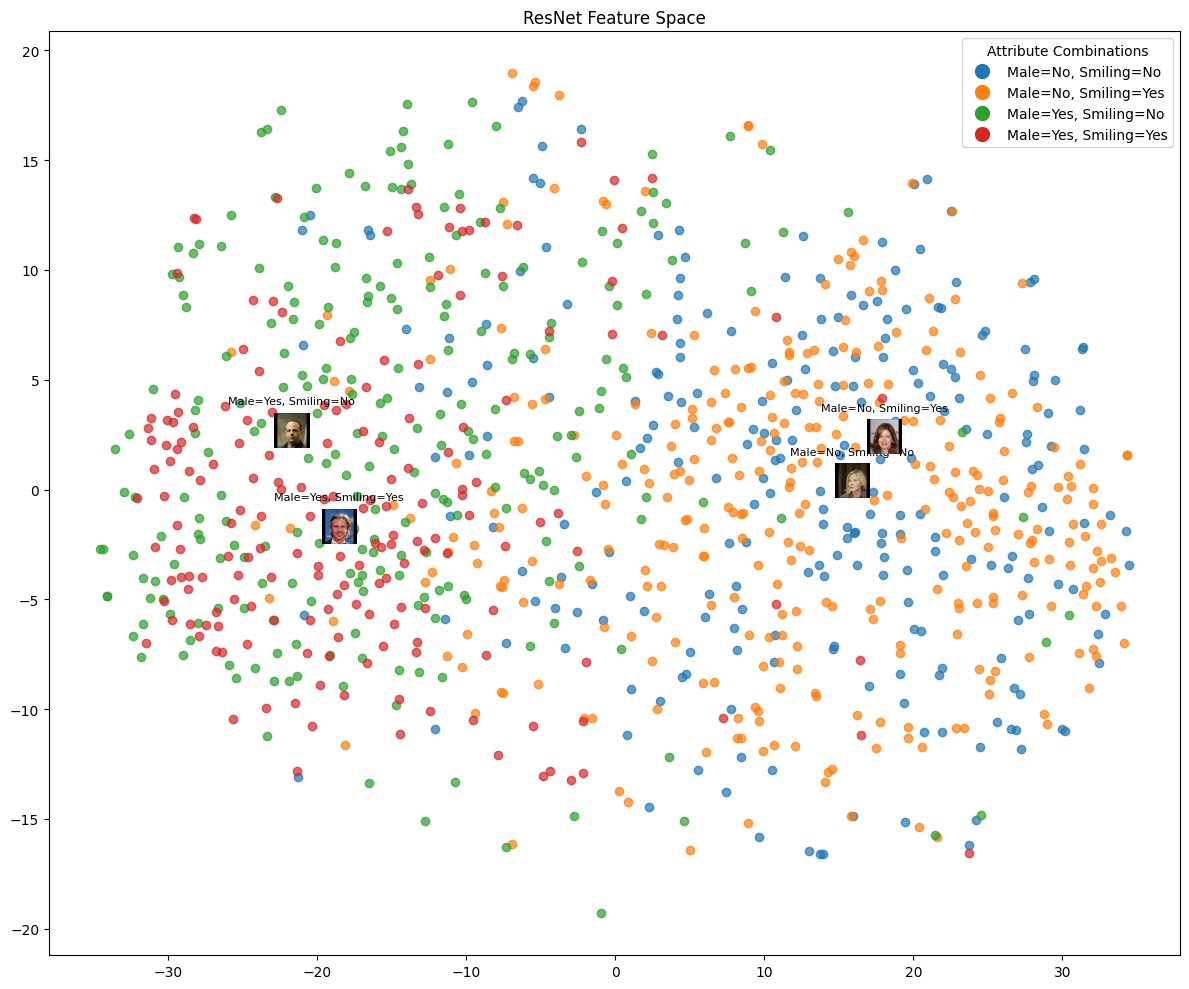

In [29]:
resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
feature_extractor = torch.nn.Sequential(*list(resnet.children())[:-1] + [nn.Flatten(start_dim=1)])
feature_extractor.eval()
process_feature_extraction(feature_extractor, test_dataloader, title='ResNet Feature Space')

## 8. Base Encoder/Decoder classes for convolutional models


## 9. Autoencoder model


In [43]:
class BaseConvEncoder(nn.Module):
    def __init__(self, input_channels=3, input_size=128, base_filters=32,
                 num_layers=7, leaky_relu_alpha=0.2, use_batch_norm=True):
        super().__init__()

        # Create sequential layers
        layers = []
        in_channels = input_channels
        current_size = input_size

        # Build encoder with increasingly more filters
        for i in range(num_layers):
            # Double filters at each layer (up to a limit)
            out_channels = base_filters * (2 ** min(i, 6))

            # Add convolutional layer (stride=2 halves dimensions)
            layers.append(nn.Conv2d(in_channels, out_channels, 3, stride=2, padding=1))
            #You could have used instead of a conv with stride=2, a nn.MaxPool2d(2, 2)
            current_size = current_size // 2  # Size after convolution with stride

            # Add batch normalization (optional, not on first layer)
            if use_batch_norm and i > 0:
                layers.append(nn.BatchNorm2d(out_channels))

            # Add activation
            layers.append(nn.LeakyReLU(leaky_relu_alpha))
            in_channels = out_channels

        # Create the model
        self.conv_layers = nn.Sequential(*layers)
        self.final_size = current_size
        self.final_channels = out_channels

    def forward(self, x):
        return self.conv_layers(x)


class BaseConvDecoder(nn.Module):
    def __init__(self, latent_dim, final_channels, final_size, base_filters=32,
                 num_layers=7, output_channels=3, output_size=128,
                 leaky_relu_alpha=0.2, use_batch_norm=True):
        super().__init__()

        # Project latent vector to starting feature map
        flattened_dim = final_channels * final_size * final_size
        self.projection = nn.Sequential(
            nn.Linear(latent_dim, flattened_dim),
            nn.LeakyReLU(leaky_relu_alpha)
        )
        self.unflatten = nn.Unflatten(1, (final_channels, final_size, final_size))

        # Create decoder layers
        layers = []

        # Build decoder with decreasing filters
        for i in range(num_layers - 1, -1, -1):
            in_channels = base_filters * (2 ** min(i, 6))
            out_channels = base_filters * (2 ** min(i - 1, 6)) if i > 0 else output_channels

            # Add transpose convolution (doubles dimensions)
            layers.append(nn.ConvTranspose2d(in_channels, out_channels, 3,
                                            stride=2, padding=1, output_padding=1))

            # Add batch norm (optional)
            if use_batch_norm and i > 0:
                layers.append(nn.BatchNorm2d(out_channels))

            # Final layer gets sigmoid activation, others get leaky ReLU
            if i > 0:
                layers.append(nn.LeakyReLU(leaky_relu_alpha))
            else:
                layers.append(nn.Sigmoid())

        self.conv_layers = nn.Sequential(*layers)

        # Handle size mismatches with adaptive pooling
        self.adaptive_layer = nn.AdaptiveAvgPool2d((output_size, output_size))

    def forward(self, latent):
        x = self.projection(latent)
        x = self.unflatten(x)
        x = self.conv_layers(x)
        x = self.adaptive_layer(x)
        return x


class Autoencoder(pl.LightningModule):
    def __init__(self, latent_dim=64, num_layers=6, input_channels=3,
                 base_filters=16, input_size=128, leaky_relu_alpha=0.2,
                 use_batch_norm=True, learning_rate=1e-3):
        super().__init__()
        self.save_hyperparameters()

        # Create encoder
        self.encoder_conv = BaseConvEncoder(input_channels, input_size, base_filters,
                                           num_layers, leaky_relu_alpha, use_batch_norm)

        # Projection to latent space
        flattened_dim = self.encoder_conv.final_channels * self.encoder_conv.final_size * self.encoder_conv.final_size
        self.projection = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_dim, latent_dim)
        )

        # Create decoder
        self.decoder_net = BaseConvDecoder(latent_dim, self.encoder_conv.final_channels,
                                          self.encoder_conv.final_size, base_filters,
                                          num_layers, input_channels, input_size,
                                          leaky_relu_alpha, use_batch_norm)

        # Loss function
        self.loss_fn = nn.MSELoss()

    def forward(self, x):
        features = self.encoder_conv(x)
        latent = self.projection(features)
        reconstruction = self.decoder_net(latent)
        return reconstruction, latent

    def encoder(self, x):
        features = self.encoder_conv(x)
        return self.projection(features)

    def _step(self, batch, batch_idx):
        x, _ = batch
        reconstruction, _ = self(x)
        loss = self.loss_fn(reconstruction, x)
        return loss

    def training_step(self, batch, batch_idx):
        loss = self._step(batch, batch_idx)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._step(batch, batch_idx)
        self.log('val_loss', loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.learning_rate, weight_decay=1e-6)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=3, verbose=True, min_lr=1e-6)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

### Autoencoder experiment

In [31]:
TRAIN_INSTEAD_OF_OR_DOWNLOAD=False #Change me to try to train another autoencoder. It will take at least 30 mins

In [32]:
if TRAIN_INSTEAD_OF_OR_DOWNLOAD:

    early_stop_callback = EarlyStopping(monitor='val_loss', patience=5, mode='min')
    checkpoint_callback = ModelCheckpoint(monitor="val_loss", dirpath="checkpoints_ae/",
                                          filename="model-{epoch:02d}-{val_loss:.4f}",
                                          save_top_k=1,
                                          mode="min", save_last=True, verbose=True)

    trainer = pl.Trainer(max_epochs=30, accelerator='auto', devices=1,
                     callbacks=[early_stop_callback, checkpoint_callback],
                     enable_progress_bar=True)
    autoencoder = Autoencoder(input_size=desired_image_size)
    trainer.fit(autoencoder, train_dataloader, val_dataloader)
    #This creates a download link
    from IPython.display import FileLink
    FileLink('checkpoints_ae/last.ckpt')
else:
    #Load the autoencoder from one of my checkpoints
    file_id = "1Owxmr0xK9ttarcIBHC64Ch_BQU3NBvlx"
    !gdown {file_id}
    checkpoint_fname = "standard_autoencoder_celebA.ckpt"
    autoencoder = Autoencoder.load_from_checkpoint(checkpoint_fname,
                                               input_size=desired_image_size,
                                               map_location="cpu")


Downloading...
From (original): https://drive.google.com/uc?id=1Owxmr0xK9ttarcIBHC64Ch_BQU3NBvlx
From (redirected): https://drive.google.com/uc?id=1Owxmr0xK9ttarcIBHC64Ch_BQU3NBvlx&confirm=t&uuid=6e26460f-d56f-45ce-9425-ce768a2b50a5
To: /content/standard_autoencoder_celebA.ckpt
100% 41.0M/41.0M [00:00<00:00, 187MB/s]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Visualizing Autoencoder Feature Space...


<ipython-input-26-b025816d3780>:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


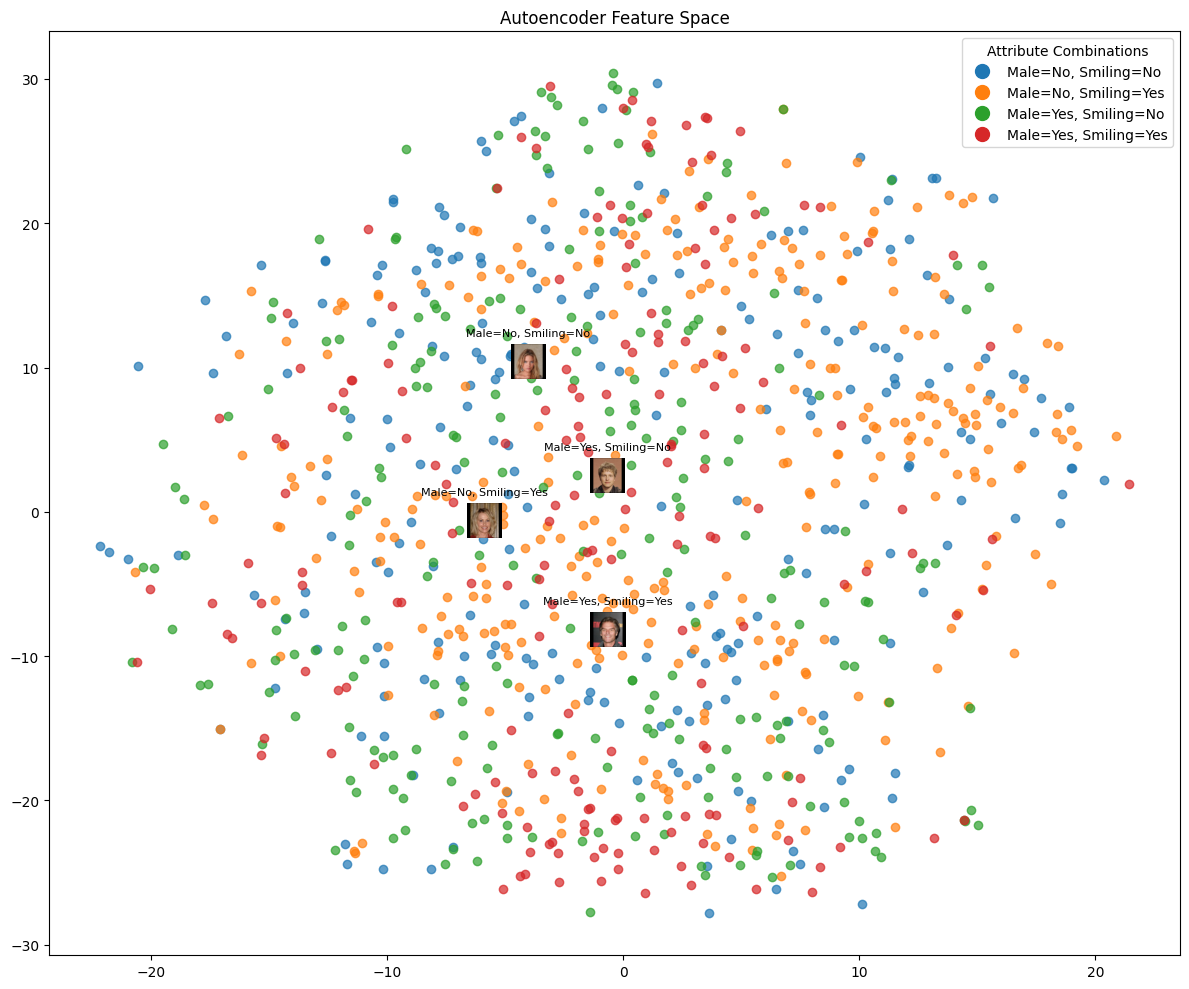

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


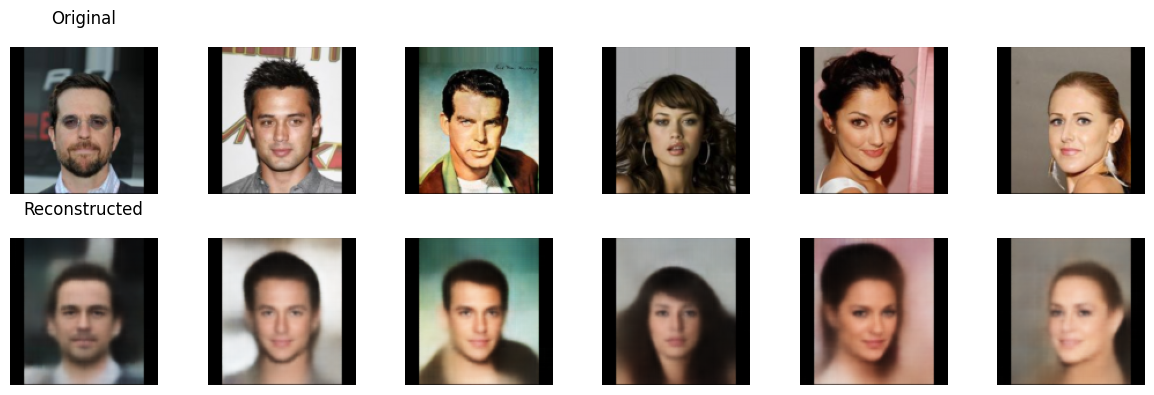

In [33]:
autoencoder.eval()
process_feature_extraction(autoencoder.encoder, test_dataloader=test_dataloader, title='Autoencoder Feature Space')
some_images, _ = next(iter(test_dataloader))
reconstructed_images, _ = autoencoder(some_images)
fig = visualize_reconstructions(some_images, reconstructed_images, num_examples=6)

If you have time, try to retrain the model making the latent space much larger (e.g, doubling it). The reconstruction quality should improve

### Autoencoder as generative model
We are going to study what happens when we generate random vectors, and feed them to the decoder

In [68]:
def visualize_latent_space_traversal(autoencoder, image1, image2, num_steps=10):
    """
    This allows us to interpolate between two images.
    """
    with torch.no_grad():
        # Get the latent representations of two images.
        latent1, *_ = autoencoder.encoder(image1.unsqueeze(0))
        latent2, *_ = autoencoder.encoder(image2.unsqueeze(0))
        # Interpolate between the two latent vectors.
        latents = [(1 - alpha) * latent1 + alpha * latent2 for alpha in torch.linspace(0, 1, num_steps)]
        # Decode each interpolated latent vector.
        recons = [autoencoder.decoder_net(latent) for latent in latents]
    fig, axes = plt.subplots(1, num_steps, figsize=(15, 3))
    for i, (ax, rec) in enumerate(zip(axes, recons)):
        ax.imshow(process_image_for_display(rec.squeeze()))
        ax.axis('off')
        if i == 0:
            ax.set_title("Image 1")
        elif i == num_steps - 1:
            ax.set_title("Image 2")
        else:
            ax.set_title(f"{int(100 * i/(num_steps-1))}%")
    plt.suptitle("Latent Space Interpolation between Two Images")
    plt.tight_layout()
    plt.show()


### Demonstrating Random Sampling vs. Interpolation in an Autoencoder

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


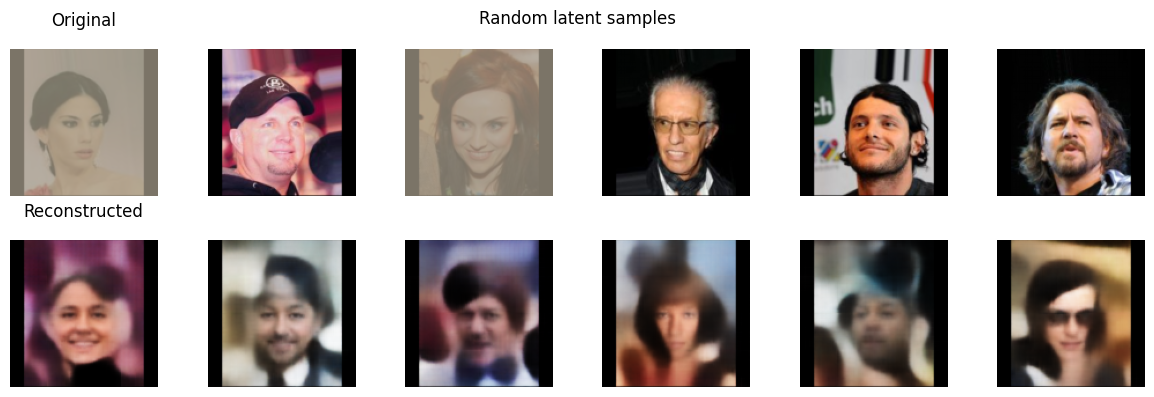

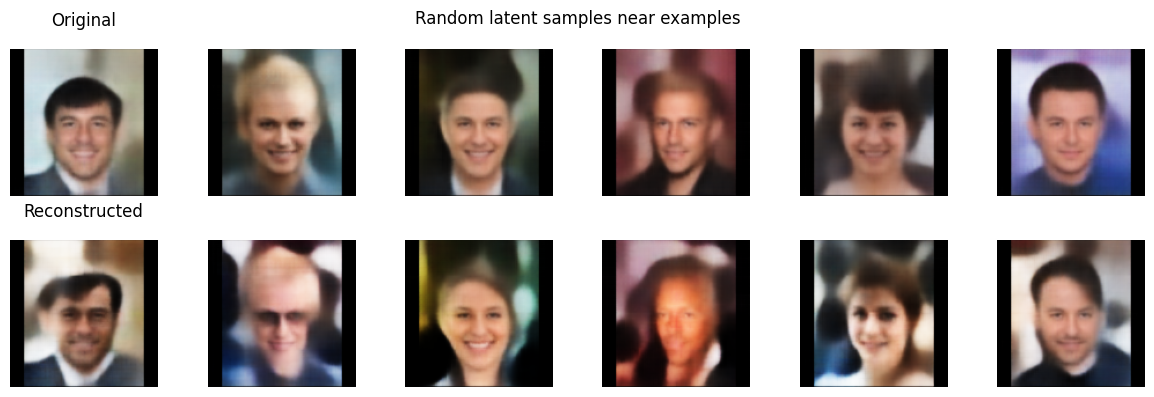

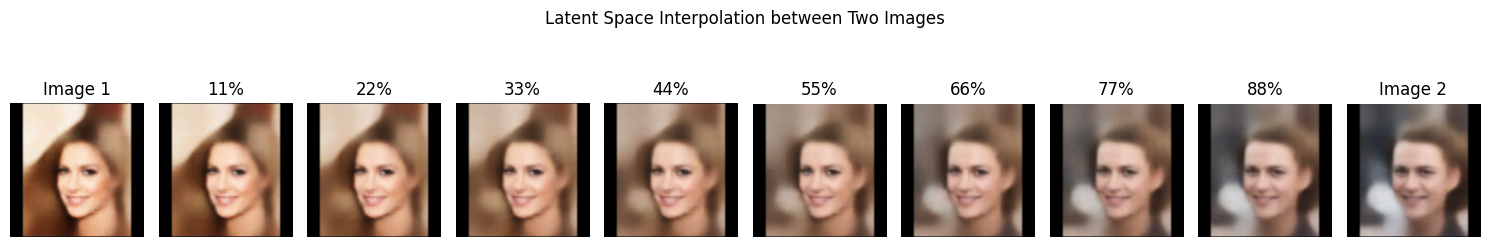

In [52]:
def random_sampling_and_interpolation(ae, test_dataloader):
  # Get a batch from the test set
  some_images, _ = next(iter(test_dataloader))

  # Obtain the latent representation from the ae
  #My autoencoder is returning 2 tensors: reconstructed image and latent vector
  #My variational autoencoders we return 3 tensors: reconstructed, mean, and std
  # For analysis purposes, we are ingoring the std, since the mean vector is the
  # latent vector with highest probability, but we could be sampling using the
  # reparametrization trick as much as we will like.
  reconstructed, latent, *_ = ae(some_images)

  # 1. Random latent sampling
  # Generate a random latent vector with the same shape as the extracted latent vectors.
  # This expression generates random points between -1 and 1 under the Uniform distribution.
  random_latent = 2*(torch.rand_like(latent)-0.5)
  recon_random = ae.decoder_net(random_latent)

  # Visualize reconstructions from random latent samples.
  fig_random = visualize_reconstructions(some_images, recon_random, num_examples=6)
  plt.suptitle("Random latent samples")
  plt.show()


  # 3. Moving around images
  # Generate a random latent vector with the same shape as the extracted latent
  # vectors and add them. You should generate images that look like the original
  # reconstructed image
  latent_perturbed = latent + 0.5 * torch.randn_like(latent)
  recon_perturbed = ae.decoder_net(latent_perturbed)

  # Visualize reconstructions from perturbed latent vectors
  fig_random = visualize_reconstructions(reconstructed, recon_perturbed, num_examples=6)
  plt.suptitle("Random latent samples near examples")
  plt.show()

  # 3. Latent space interpolation between two images

  # Pick two images from the batch
  image1 = some_images[0]
  image2 = some_images[1]
  # Perform interpolation and visualize the results
  visualize_latent_space_traversal(ae, image1, image2)

random_sampling_and_interpolation(autoencoder, test_dataloader)

### Exercise


Implement code to find similar examples
- in image space (hint, you can clusterize based on labels).
- in latent space.
  
Can you try to perform interpolation using different pairs of images? The more similar the images, the better the quality of the interpolated reconstructions should be.

You can also try to check that pixelwise image to image distances are meaningless, while distances in latent spaces are much more informative.

## 10. Variational Autoencoder (VAE)


In [65]:
class VAEEncoder(nn.Module):
    def __init__(self, input_channels=3, input_size=128,
                 base_filters=16, num_layers=8, latent_dim=256, leaky_relu_alpha=0.2,
                 use_batch_norm=True):
        super().__init__()

        # Create convolutional encoder backbone
        self.encoder_conv = BaseConvEncoder(input_channels, input_size,
                                          base_filters, num_layers, leaky_relu_alpha, use_batch_norm)

        # Calculate flattened dimension after convolutions
        flattened_dim = self.encoder_conv.final_channels * self.encoder_conv.final_size * self.encoder_conv.final_size

        # Create layers for variational parameters (mean and log-variance)
        self.fc_mu = nn.Linear(flattened_dim, latent_dim)
        self.fc_logvar = nn.Linear(flattened_dim, latent_dim)

    def forward(self, x):
        # Get convolutional features
        features = self.encoder_conv(x)

        # Flatten and project to latent parameters
        flattened = torch.flatten(features, start_dim=1)
        mu = self.fc_mu(flattened)
        logvar = self.fc_logvar(flattened)

        return mu, logvar, features


class VariationalAutoencoder(pl.LightningModule):
    def __init__(self, latent_dim=256, num_layers=7, input_channels=3, base_filters=16,
                 input_size=128, leaky_relu_alpha=0.2, use_batch_norm=True,
                 learning_rate=1e-3, beta=1.0):
        super().__init__()
        self.save_hyperparameters()

        # Create encoder network
        self.encoder_net = VAEEncoder(input_channels, input_size,
                                    base_filters, num_layers, latent_dim,
                                    leaky_relu_alpha, use_batch_norm)

        # Create decoder network
        self.decoder_net = BaseConvDecoder(latent_dim,
                                         self.encoder_net.encoder_conv.final_channels,
                                         self.encoder_net.encoder_conv.final_size,
                                         base_filters, num_layers, input_channels,
                                         input_size, leaky_relu_alpha, use_batch_norm)

        # Loss function
        self.reconstruction_loss_fn = nn.MSELoss(reduction='sum')

    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick: z = mu + std * eps
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        z, mu, logvar = self.encoder(x, requires_sampling=True)
        # Decode the latent sample
        reconstruction = self.decoder_net(z)

        return reconstruction, mu, logvar

    def encoder(self, x, requires_sampling=True):
        """
        Encode input to latent space
        """
        mu, logvar, _ = self.encoder_net(x)
        return self.reparameterize(mu, logvar), mu, logvar


    def compute_kl_divergence(self, mu, logvar):
        """
        Compute KL divergence between N(mu, sigma) and N(0, 1)
        """
        return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    def training_step(self, batch, batch_idx):
        x, _ = batch
        batch_size = x.size(0)

        # Forward pass
        reconstruction, mu, logvar = self(x)

        # Compute losses
        recon_loss = self.reconstruction_loss_fn(reconstruction, x) / batch_size
        kl_loss = self.compute_kl_divergence(mu, logvar) / batch_size

        # Total loss = reconstruction loss + beta * KL divergence
        loss = recon_loss + self.hparams.beta * kl_loss

        # Log metrics
        self.log('train_loss', loss, prog_bar=True)
        self.log('recon_loss', recon_loss, prog_bar=True)
        self.log('kl_loss', kl_loss, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        """
        Added validation step (was missing in original)
        """
        x, _ = batch
        batch_size = x.size(0)

        reconstruction, mu, logvar = self(x)
        recon_loss = self.reconstruction_loss_fn(reconstruction, x) / batch_size
        kl_loss = self.compute_kl_divergence(mu, logvar) / batch_size
        loss = recon_loss + self.hparams.beta * kl_loss

        self.log('val_loss', loss, prog_bar=True)
        self.log('val_recon_loss', recon_loss)
        self.log('val_kl_loss', kl_loss)

        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.1, patience=5, verbose=True, min_lr=1e-6)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

In [66]:
if TRAIN_INSTEAD_OF_OR_DOWNLOAD:
    vae = VariationalAutoencoder(input_size=desired_image_size,
                                 learning_rate=1e-2, beta=1.0)
    early_stop_callback = EarlyStopping(monitor='train_loss', patience=3, mode='min')
    checkpoint_callback = ModelCheckpoint(monitor="train_loss", dirpath="checkpoints_vae/",
                                          filename="model-{epoch:02d}-{val_loss:.3f}", save_top_k=1,
                                          mode="min", save_last=True, verbose=True)
    trainer = pl.Trainer(max_epochs=30, accelerator='auto', devices=1,
                         callbacks=[early_stop_callback, checkpoint_callback],
                         enable_progress_bar=True)
    trainer.fit(vae, train_dataloader, val_dataloader)
    from IPython.display import FileLink
    FileLink('checkpoints_vae/last.ckpt')
else:
    #Load the autoencoder from one of my checkpoints
    file_id = "1EICfiWOIoSXYfzI13NTPi7NriTd6S6cO"
    !gdown {file_id}
    checkpoint_fname = "vae_celebA.ckpt"
    vae = VariationalAutoencoder.load_from_checkpoint(checkpoint_fname,
                                                               map_location="cpu")

Downloading...
From (original): https://drive.google.com/uc?id=1EICfiWOIoSXYfzI13NTPi7NriTd6S6cO
From (redirected): https://drive.google.com/uc?id=1EICfiWOIoSXYfzI13NTPi7NriTd6S6cO&confirm=t&uuid=7b202c0e-2bd8-4a95-a60c-72ff0b56cb9e
To: /content/vae_celebA.ckpt
100% 161M/161M [00:00<00:00, 183MB/s]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Visualizing VAE Feature Space...


<ipython-input-26-b025816d3780>:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


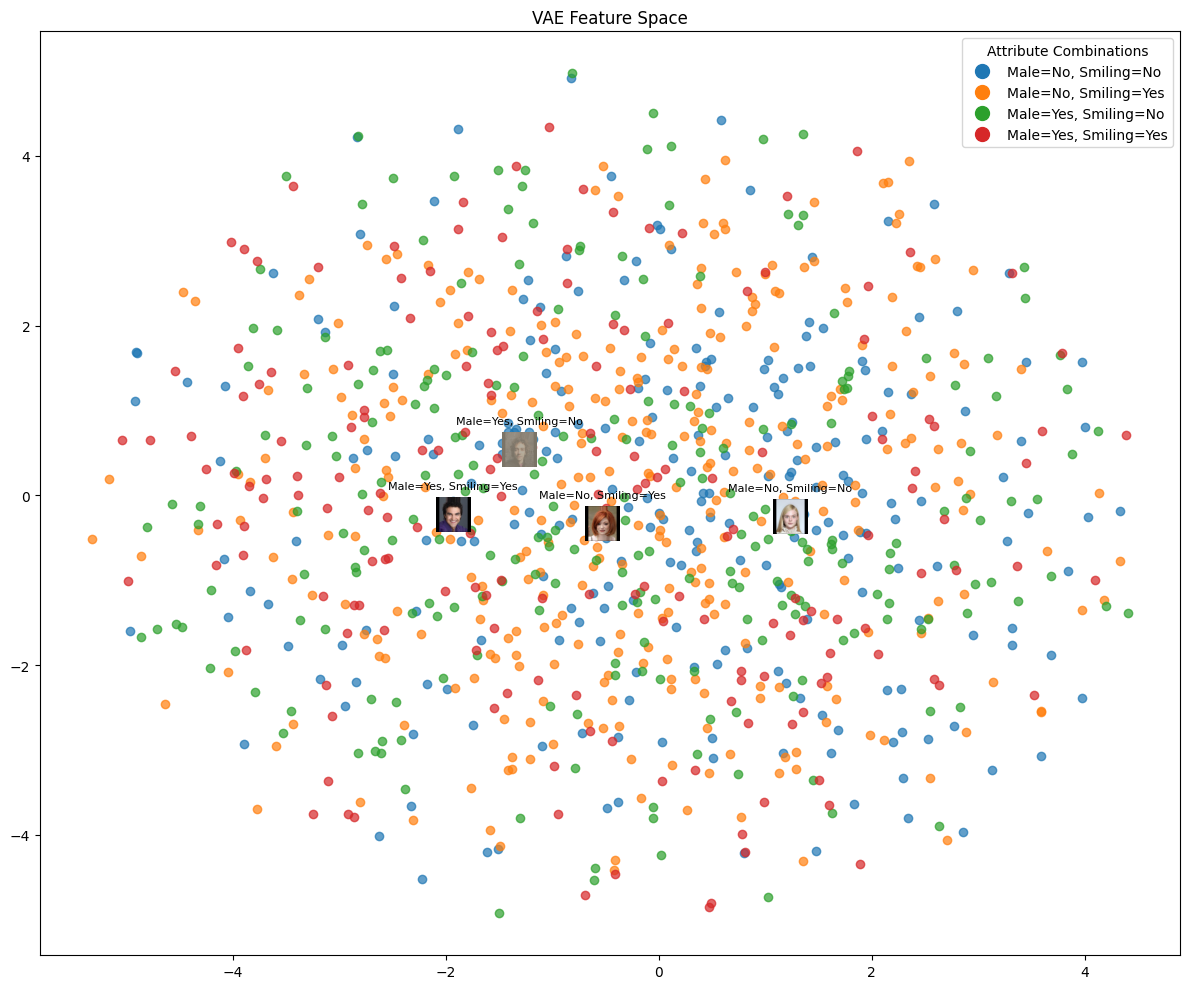

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


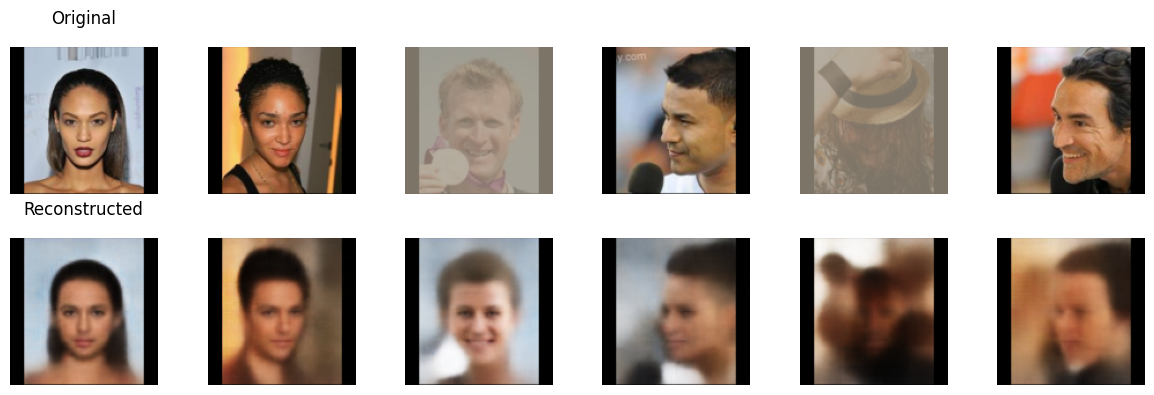

In [71]:
vae.eval()
feature_extractor = lambda x: vae.encoder(x)[0]
process_feature_extraction(feature_extractor, test_dataloader=test_dataloader, title='VAE Feature Space')
some_images, _ = next(iter(test_dataloader))
reconstructed_images, _, _ = vae(some_images)
fig = visualize_reconstructions(some_images, reconstructed_images, num_examples=6)


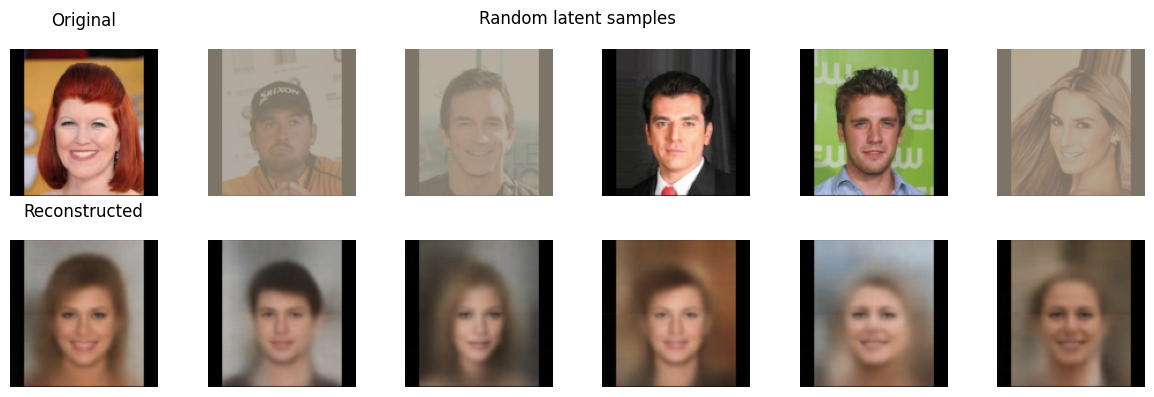

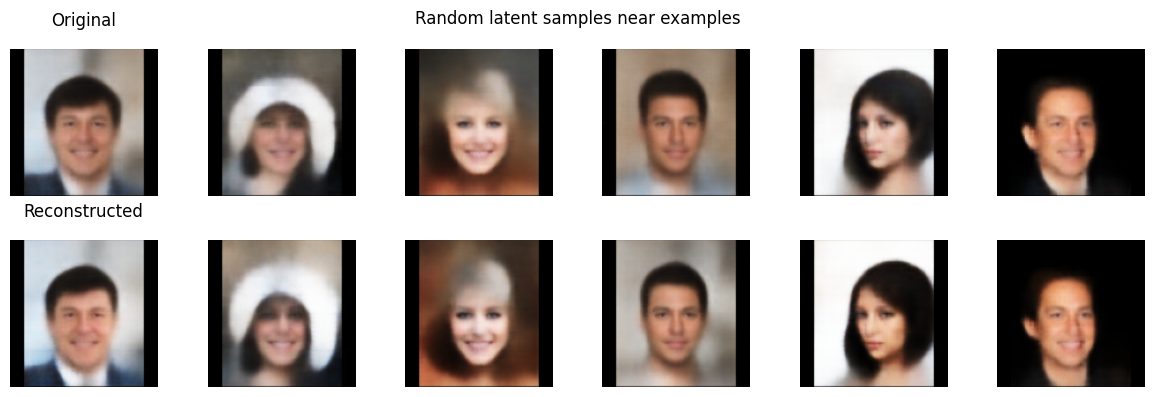

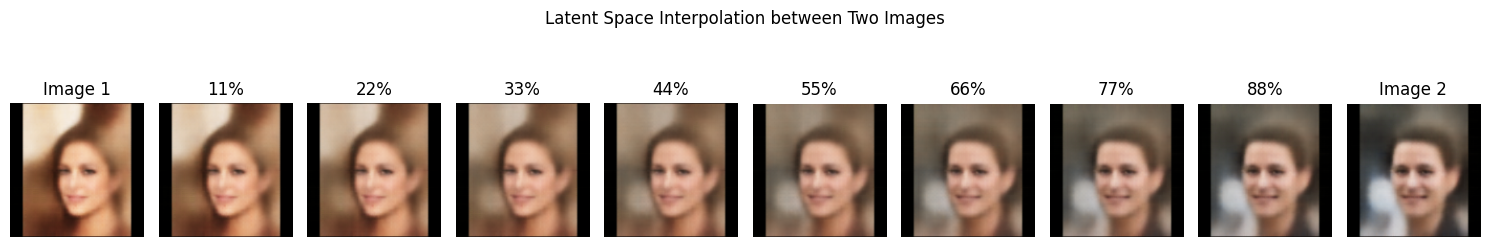

In [72]:
random_sampling_and_interpolation(vae, test_dataloader)

## 11. Arithmetics on vector spaces

### Utility code to extract different image types and to operate in the latent space

In [85]:
def extract_celeba_attributes(celeba_dataset):
    attributes = []
    for i in range(len(celeba_dataset)):
        _, attr = celeba_dataset[i]
        attr_np = attr.numpy() if torch.is_tensor(attr) else np.array(attr)
        if (attr_np < 0).any():
            attr_np = (attr_np > 0).astype(int)
        attributes.append(attr_np)
    sample_attr = attributes[0]
    if isinstance(sample_attr, np.ndarray) and sample_attr.ndim == 1:
        attr_names = celeba_dataset.attr_names if hasattr(celeba_dataset, 'attr_names') else celeba_attrs
        if len(sample_attr) != len(attr_names):
            attr_names = [f'attr_{i}' for i in range(len(sample_attr))]
        attributes_df = pd.DataFrame(attributes, columns=attr_names)
    else:
        attributes_df = pd.DataFrame(attributes)
    print("Available attributes:", attributes_df.columns.tolist())
    print(f"Attributes extracted. Shape: {attributes_df.shape}")
    return attributes_df

def get_latent_vectors(model, images):
    model.eval()
    with torch.no_grad():
        _, z, _ = model.encoder(images) #We just take the mean
    return z


def decode_and_visualize(model, original_img, original_z, modified_z, title="Latent Space Arithmetic"):
    model.eval()
    with torch.no_grad():
        rec_orig = model.decoder_net(original_z)
        transformed = model.decoder_net(modified_z)
    # Process for display
    orig_np = process_image_for_display(original_img.squeeze(0))
    rec_np = process_image_for_display(rec_orig.squeeze(0))
    trans_np = process_image_for_display(transformed.squeeze(0))
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(orig_np); axes[0].set_title("Original Image"); axes[0].axis('off')
    axes[1].imshow(rec_np); axes[1].set_title("Reconstructed Image"); axes[1].axis('off')
    axes[2].imshow(trans_np); axes[2].set_title("Transformed Image"); axes[2].axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    return fig

def find_images_by_attributes(celeba_attributes, attr_conditions, dataset, max_samples=30):
    """
    Find indices of images that match the given attribute conditions

    Args:
        celeba_attributes: DataFrame with attributes
        attr_conditions: Dict with attribute conditions (e.g., {'Male': 0, 'Smiling': 1})
        max_samples: Maximum number of samples to return

    Returns:
        Array of indices matching the conditions
    """
    # Validate that all required attributes exist
    for attr in attr_conditions.keys():
        if attr not in celeba_attributes.columns:
            print(f"Warning: Attribute '{attr}' not found in dataset. Available attributes: {celeba_attributes.columns.tolist()[:10]}...")
            return []

    # Find matching images
    mask = np.ones(len(celeba_attributes), dtype=bool)
    for attr, value in attr_conditions.items():
        mask &= (celeba_attributes[attr] == value)

    # Get indices
    indices = np.where(mask)[0]

    # Limit number of examples
    indices = indices[:max_samples]
    imgs = torch.stack([celeba_dataset[i][0] for i in indices])
    print(f"{len(imgs)} found for {attr_conditions}")
    return imgs, indices

### Preparing data for the vector arithmetic *experiment*

In [40]:
celeba_dataset = test_dataloader.dataset
celeba_attributes = extract_celeba_attributes(celeba_dataset)

Available attributes: ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']
Attributes extracted. Shape: (1000, 40)


### Add glasses to woman

a_woman_with_glasses = a_woman_without_glasses + glasseness_vector

We can estimate the glasseness vector by computing the difference between people with glassess and people without glassess. <br>

glasseness_vector = mean_vector_people_with_glassess - mean_vector_people_witout_glasses

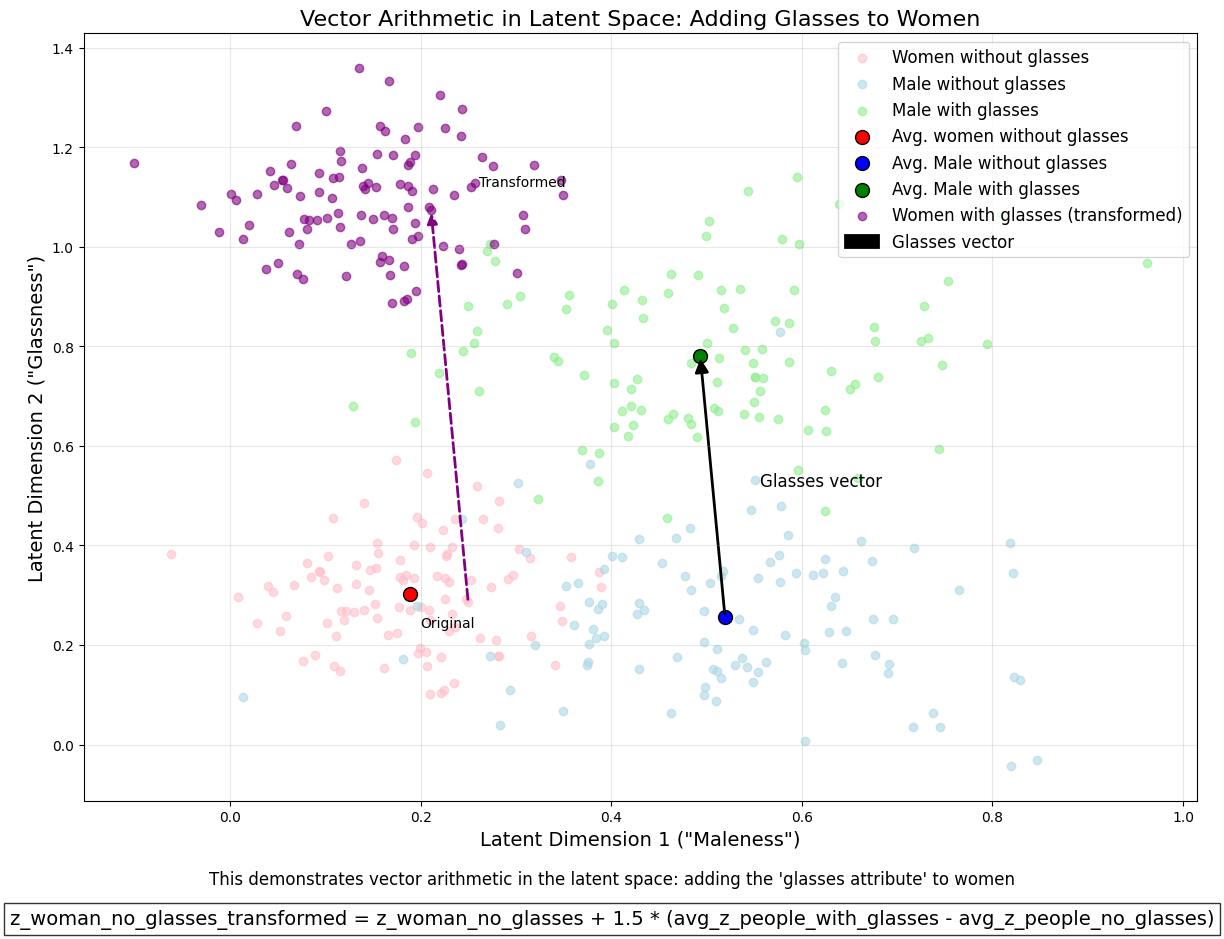

CONCEPTUAL EXPLANATION OF THE LATENT VECTOR ARITHMETIC
The provided code is performing vector arithmetic in the latent space of a VAE.
Here's what it's doing step by step:

1. Finding images by attributes:
   - Women without glasses: Female faces without eyeglasses
   - People without glasses: All faces without eyeglasses
   - People with glasses: All faces with eyeglasses

2. Getting latent vectors:
   - Encoding all these images into the VAE's latent space
   - Each image becomes a point in high-dimensional latent space

3. Calculating average latent vectors:
   - Finding the center (average) of each group in latent space

4. Vector arithmetic:
   - Computing the 'glasses vector' = avg_male_with_glasses - avg_male_no_glasses
   - This vector represents the direction of 'adding glasses' in latent space
   - Scaling this vector by 1.5 to make the effect stronger
   - Adding this scaled vector to each woman's latent vector

5. Decoding and visualizing:
   - Converting the transformed la

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from sklearn.decomposition import PCA
import torch
import random
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
np.random.seed(42)
random.seed(42)

# Let's create a simplified 2D representation of what's happening in the latent space

# First, let's simulate some latent vectors (normally these would come from a VAE)
# We'll create synthetic data to represent our three groups
def generate_cluster(n_samples, center, std):
    return np.random.normal(center, std, size=(n_samples, 2))

# Parameters to create the three clusters
n_samples = 100

# Create our three clusters
# For women without glasses: low on "maleness" axis, low on "glassness" axis
women_no_glasses = generate_cluster(n_samples, center=[0.2, 0.3], std=0.1)

# For people without glasses: medium on "maleness" axis, low on "glassness" axis
people_no_glasses = generate_cluster(n_samples, center=[0.5, 0.25], std=0.15)

# For people with glasses: medium on "maleness" axis, high on "glassness" axis
people_with_glasses = generate_cluster(n_samples, center=[0.5, 0.8], std=0.15)

# Calculate the average (centroid) of each cluster
avg_women_no_glasses = women_no_glasses.mean(axis=0)
avg_people_no_glasses = people_no_glasses.mean(axis=0)
avg_people_with_glasses = people_with_glasses.mean(axis=0)

# Calculate the "glasses vector" - the difference between people with and without glasses
glasses_vector = avg_people_with_glasses - avg_people_no_glasses

# Apply the transformation: women_no_glasses + 1.5 * glasses_vector
women_transformed = women_no_glasses + 1.5 * glasses_vector

# Create the visualization
plt.figure(figsize=(12, 10))

# Plot all the points
plt.scatter(women_no_glasses[:, 0], women_no_glasses[:, 1], alpha=0.6, c='pink', label='Women without glasses')
plt.scatter(people_no_glasses[:, 0], people_no_glasses[:, 1], alpha=0.6, c='lightblue', label='Male without glasses')
plt.scatter(people_with_glasses[:, 0], people_with_glasses[:, 1], alpha=0.6, c='lightgreen', label='Male with glasses')

# Plot the centroids
plt.scatter(avg_women_no_glasses[0], avg_women_no_glasses[1], c='red', s=100, edgecolor='black', label='Avg. women without glasses')
plt.scatter(avg_people_no_glasses[0], avg_people_no_glasses[1], c='blue', s=100, edgecolor='black', label='Avg. Male without glasses')
plt.scatter(avg_people_with_glasses[0], avg_people_with_glasses[1], c='green', s=100, edgecolor='black', label='Avg. Male with glasses')

# Plot the transformed women points (women with glasses)
plt.scatter(women_transformed[:, 0], women_transformed[:, 1], alpha=0.6, c='purple', label='Women with glasses (transformed)')

# Draw the "glasses vector" arrow
glasses_arrow = FancyArrowPatch(
    avg_people_no_glasses,
    avg_people_with_glasses,
    arrowstyle='-|>',
    color='black',
    lw=2,
    mutation_scale=20,
    label='Glasses vector'
)
plt.gca().add_patch(glasses_arrow)

# Add a text label for the glasses vector
arrow_midpoint = (avg_people_no_glasses + avg_people_with_glasses) / 2
plt.text(arrow_midpoint[0] + 0.05, arrow_midpoint[1], 'Glasses vector', fontsize=12)

# Show example of transformation for one point
example_idx = 0
example_arrow = FancyArrowPatch(
    women_no_glasses[example_idx],
    women_transformed[example_idx],
    arrowstyle='-|>',
    color='purple',
    lw=2,
    linestyle='--',
    mutation_scale=15
)
plt.gca().add_patch(example_arrow)
plt.text(women_no_glasses[example_idx, 0] - 0.05, women_no_glasses[example_idx, 1] - 0.05,
         'Original', fontsize=10)
plt.text(women_transformed[example_idx, 0] + 0.05, women_transformed[example_idx, 1] + 0.05,
         'Transformed', fontsize=10)

# Annotate the formula
formula_text = "z_woman_no_glasses_transformed = z_woman_no_glasses + 1.5 * (avg_z_people_with_glasses - avg_z_people_no_glasses)"
plt.figtext(0.5, 0.02, formula_text, ha='center', fontsize=14, bbox=dict(facecolor='white', alpha=0.8))

# Add a reference to the concept
plt.figtext(0.5, 0.06, "This demonstrates vector arithmetic in the latent space: adding the 'glasses attribute' to women",
            ha='center', fontsize=12)

# Add labels and title
plt.xlabel('Latent Dimension 1 ("Maleness")', fontsize=14)
plt.ylabel('Latent Dimension 2 ("Glassness")', fontsize=14)
plt.title('Vector Arithmetic in Latent Space: Adding Glasses to Women', fontsize=16)
plt.legend(loc='upper right', fontsize=12)
plt.grid(alpha=0.3)


plt.tight_layout(rect=[0, 0.08, 1, 0.95])  # Adjust layout to make room for the bottom text
plt.show()

# Function to demonstrate the full process
def illustrate_latent_vector_arithmetic():
    """
    Illustrate the complete process with a toy example that mimics the VAE latent space
    manipulations shown in the original code.
    """
    print("CONCEPTUAL EXPLANATION OF THE LATENT VECTOR ARITHMETIC")
    print("=" * 70)
    print("The provided code is performing vector arithmetic in the latent space of a VAE.")
    print("Here's what it's doing step by step:")

    print("\n1. Finding images by attributes:")
    print("   - Women without glasses: Female faces without eyeglasses")
    print("   - People without glasses: All faces without eyeglasses")
    print("   - People with glasses: All faces with eyeglasses")

    print("\n2. Getting latent vectors:")
    print("   - Encoding all these images into the VAE's latent space")
    print("   - Each image becomes a point in high-dimensional latent space")

    print("\n3. Calculating average latent vectors:")
    print("   - Finding the center (average) of each group in latent space")

    print("\n4. Vector arithmetic:")
    print("   - Computing the 'glasses vector' = avg_male_with_glasses - avg_male_no_glasses")
    print("   - This vector represents the direction of 'adding glasses' in latent space")
    print("   - Scaling this vector by 1.5 to make the effect stronger")
    print("   - Adding this scaled vector to each woman's latent vector")

    print("\n5. Decoding and visualizing:")
    print("   - Converting the transformed latent vectors back to images")
    print("   - The result should be women with glasses added")

    print("\nKey insight: The latent space organizes semantic features so that directions")
    print("correspond to interpretable changes to the images (like adding glasses)")

# Run the explanation function
illustrate_latent_vector_arithmetic()

100 found for {'Male': 0, 'Eyeglasses': 0}
100 found for {'Eyeglasses': 0}
65 found for {'Eyeglasses': 1}


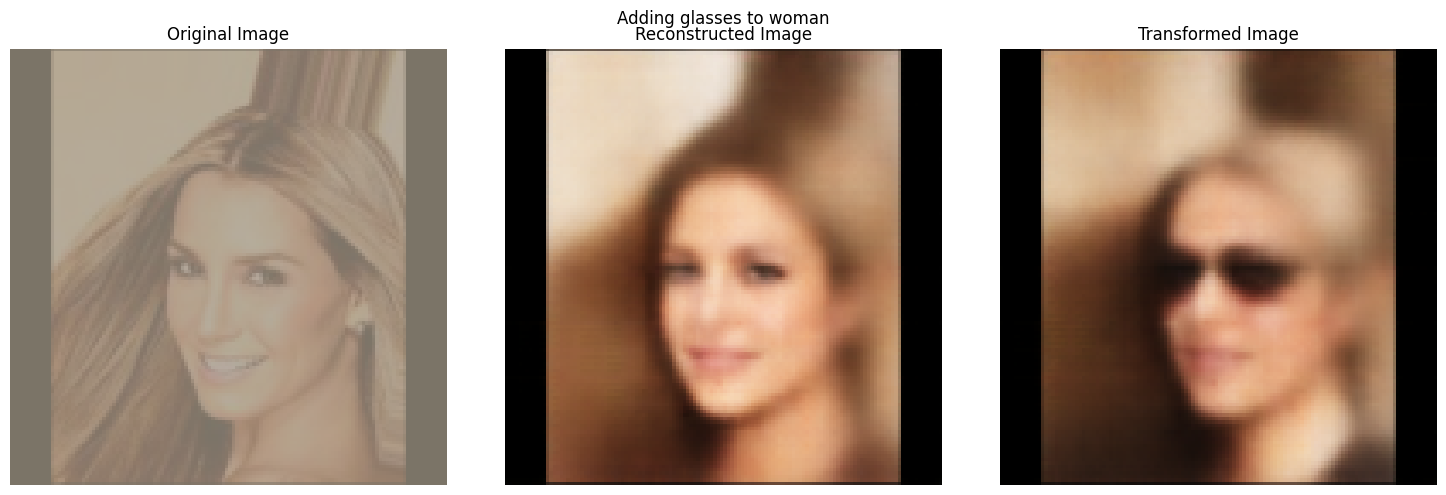

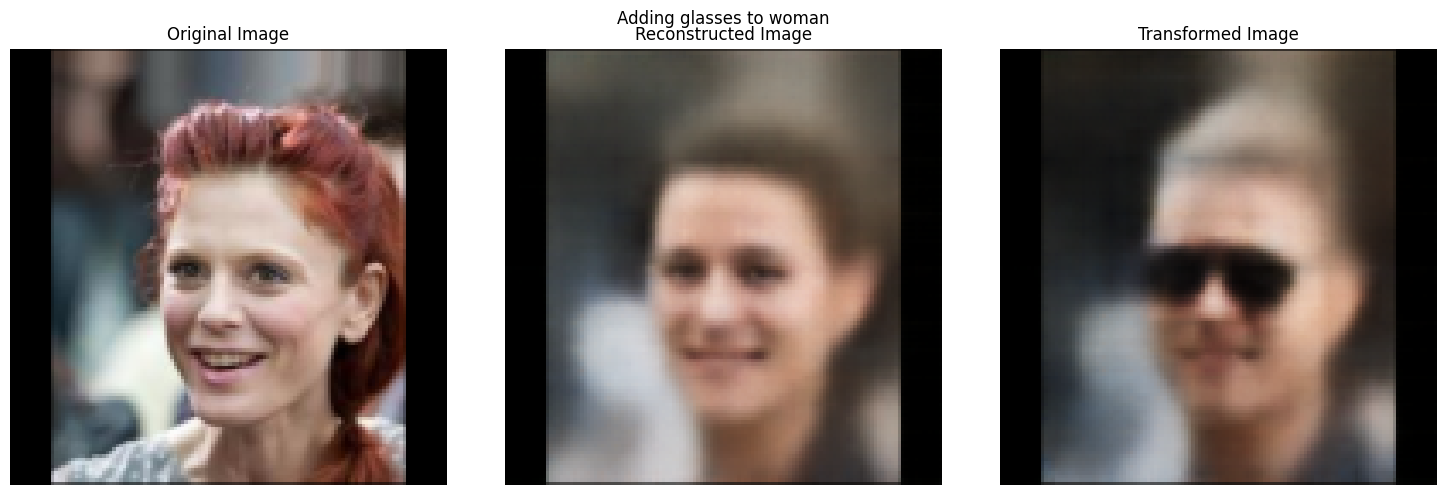

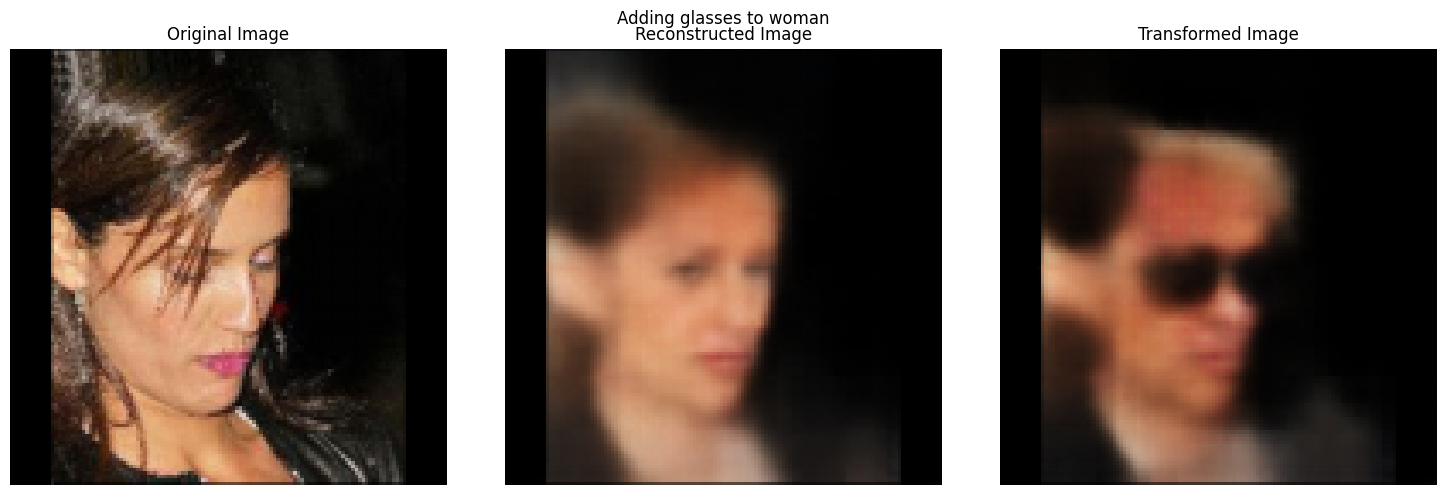

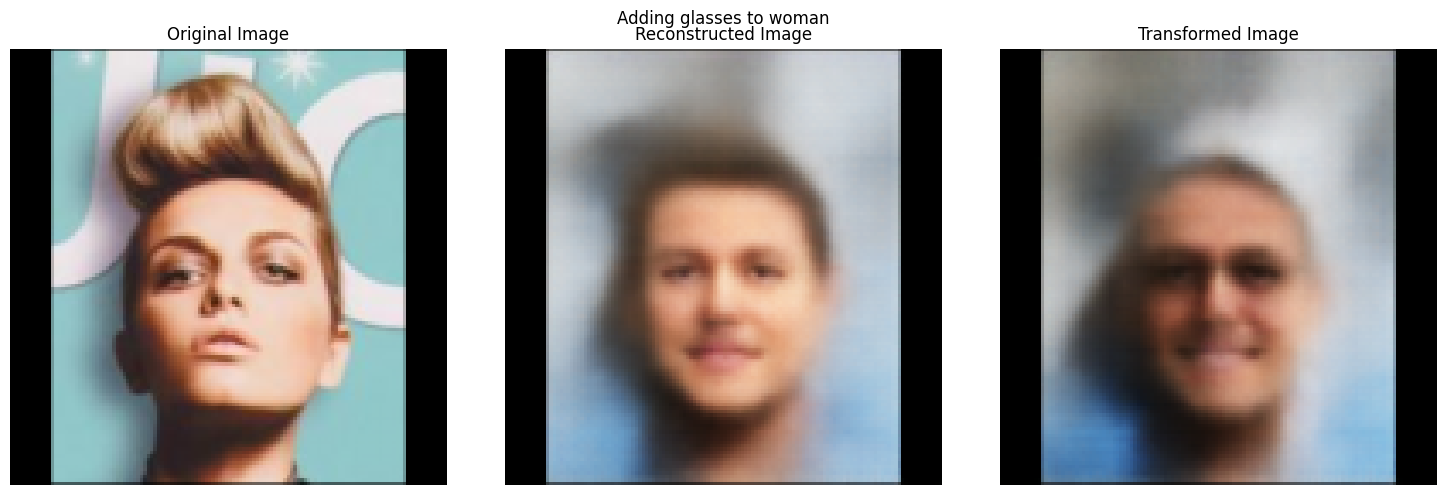

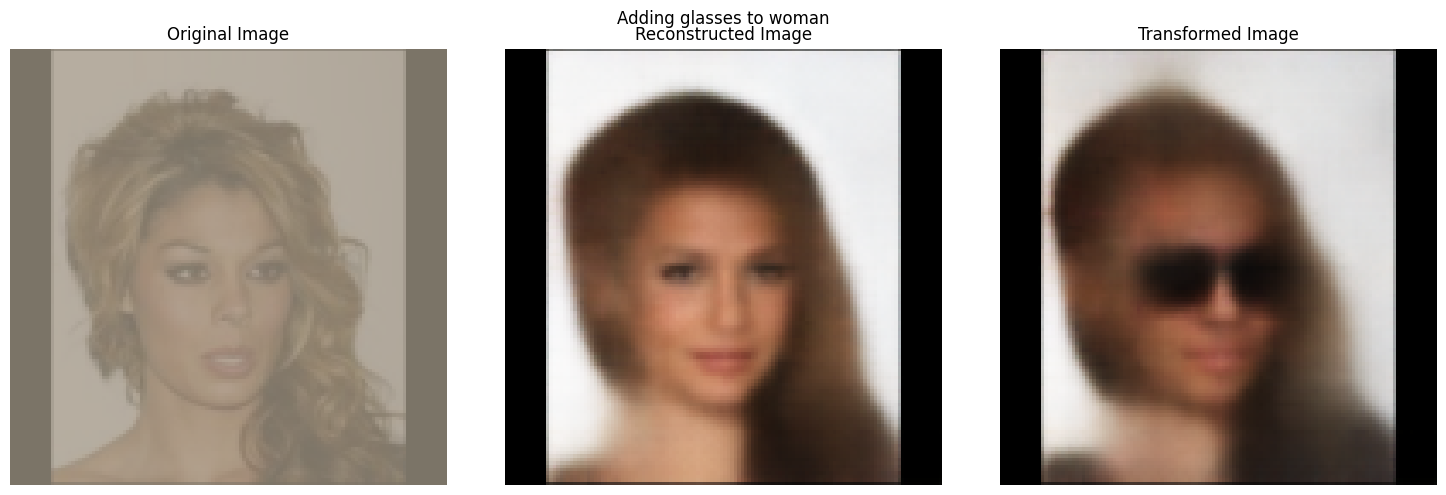

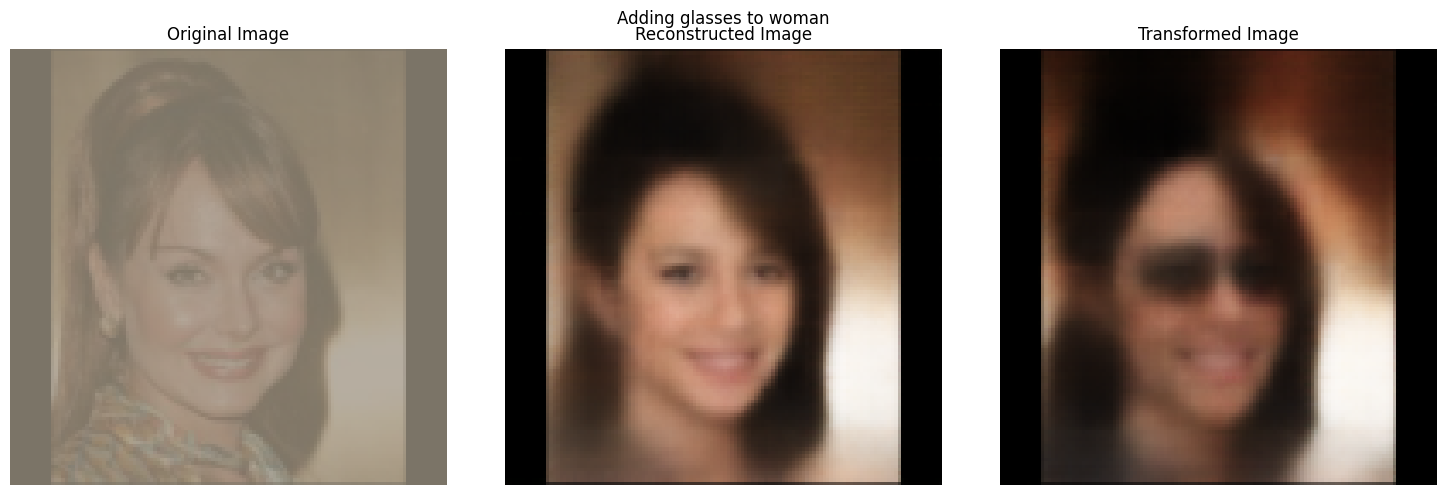

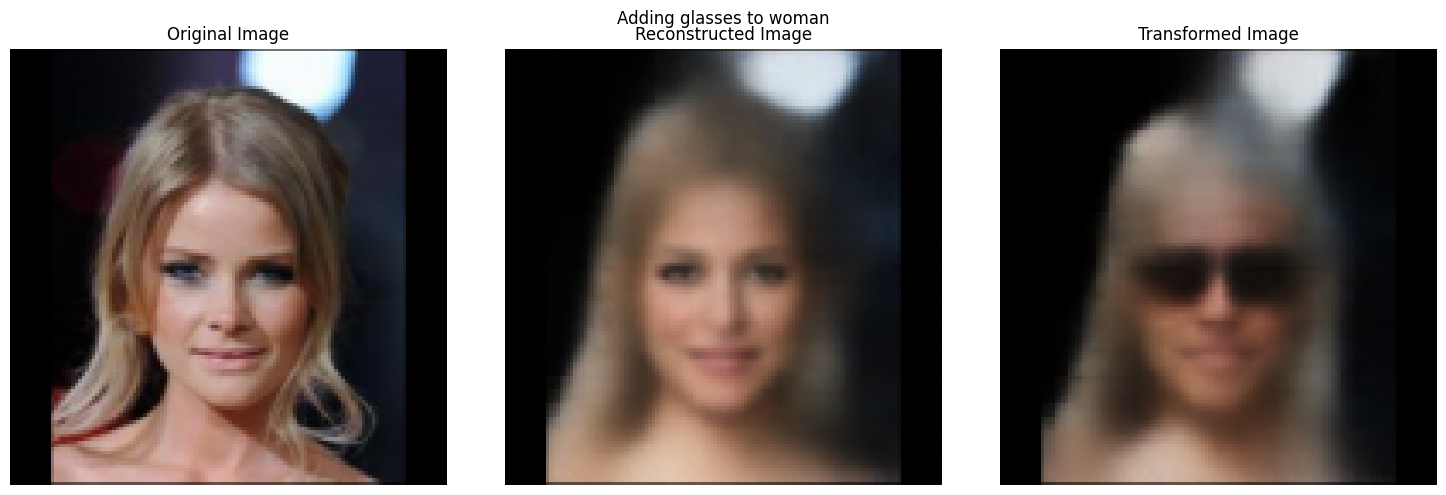

In [78]:
woman_no_glasses, _ = find_images_by_attributes(celeba_attributes,
                                                attr_conditions={'Male': 0, 'Eyeglasses': 0},
                                                dataset=celeba_dataset, max_samples=100)

people_no_glasses, _ = find_images_by_attributes(celeba_attributes,
                                                attr_conditions={'Eyeglasses': 0},
                                                dataset=celeba_dataset, max_samples=100)
people_with_glasses, _ = find_images_by_attributes(celeba_attributes,
                                                attr_conditions={'Eyeglasses': 1},
                                                dataset=celeba_dataset, max_samples=100)


z_woman_no_glasses = get_latent_vectors(vae, woman_no_glasses)

z_people_no_glasses = get_latent_vectors(vae, people_no_glasses)
z_people_with_glasses = get_latent_vectors(vae, people_with_glasses)

avg_z_woman_no_glasses = z_woman_no_glasses.mean(dim=0, keepdim=True)

avg_z_people_no_glasses = z_people_no_glasses.mean(dim=0, keepdim=True)
avg_z_people_with_glasses = z_people_with_glasses.mean(dim=0, keepdim=True)

scaling_strength = 2 #Moving a factor of two in glasses direction
z_woman_no_glasses_transformed = z_woman_no_glasses + \
                                scaling_strength * (avg_z_people_with_glasses-avg_z_people_no_glasses)


for i in range(woman_no_glasses.shape[0]):
    decode_and_visualize(vae, woman_no_glasses[i:i+1],
                         z_woman_no_glasses[i:i+1],
                         z_woman_no_glasses_transformed[i:i+1],
                         title="Adding glasses to woman")
    if i > 5: break


### Exercise
Can you try other combinations?